<a href="https://colab.research.google.com/github/jc39963/ML_Court/blob/main/machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jc39963/ML_Court/blob/main/machine_learning_court.ipynb)

# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [2]:
!pip install lime
#pip install anchor_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=49eb8d9d3e0f89aaf26e54cc05aa32c27b10af44c9c5d832b3499f7e45758fc0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


Original Code:
- Eval metrics are all 1.0 because when looking at actual unique y-values, they are all 0s. This is because the LabelEncoder was ran first, setting everything to 0 and 1, so when the line of code `y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)` was run, it would only apply 0 to everything because nothing would meet the condition of `>50k`. As a result, the model will predict everything as 0 (or denied), so we see Jane denied. Additionally, none of the SHAP values or feature importance really show anything because everything is denied in the data.

In [24]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
import numpy as np
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
#import anchor_tabular
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean and preprocess
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()


for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



Edited code:
- I moved the line `y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)` above the LabelEncoder so that there would actually be 2 classes in our outcome data so the model would actually run without predicting and having all denials.

In [25]:


# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean and preprocess
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

#move the class encoding before label encoder so they are correctly encoded
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)


for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6842
           1       0.72      0.61      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.80      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045



In [26]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Prediction for Jane Dow (Loan Eligibility): Denied


**Getting SHAP Values**

In [5]:
# Compute SHAP values
# Code from explainable-ml-example notebook

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(model_adult, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

100%|===================| 18081/18090 [23:06<00:00]       

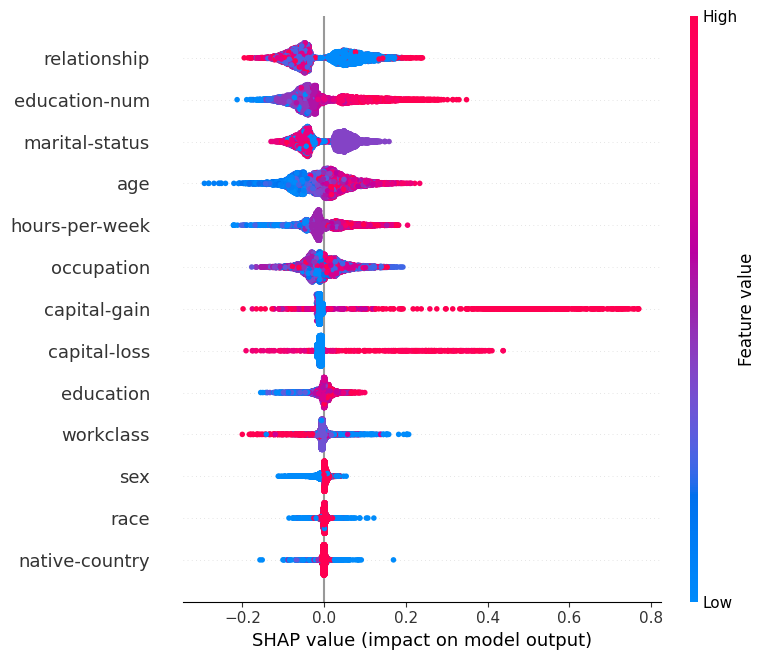

In [21]:
shap.summary_plot(shap_values[:, :, 1], X_test)

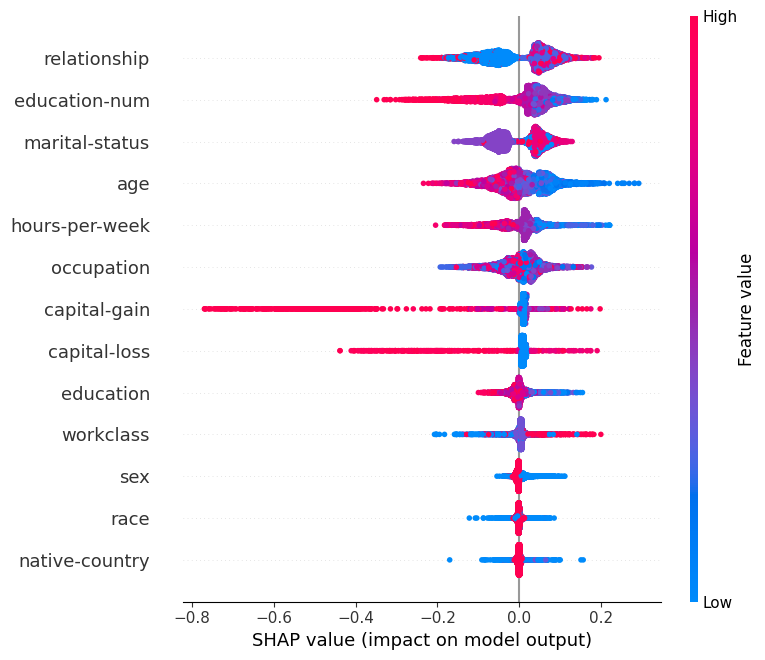

In [22]:
shap.summary_plot(shap_values[:, :, 0], X_test)

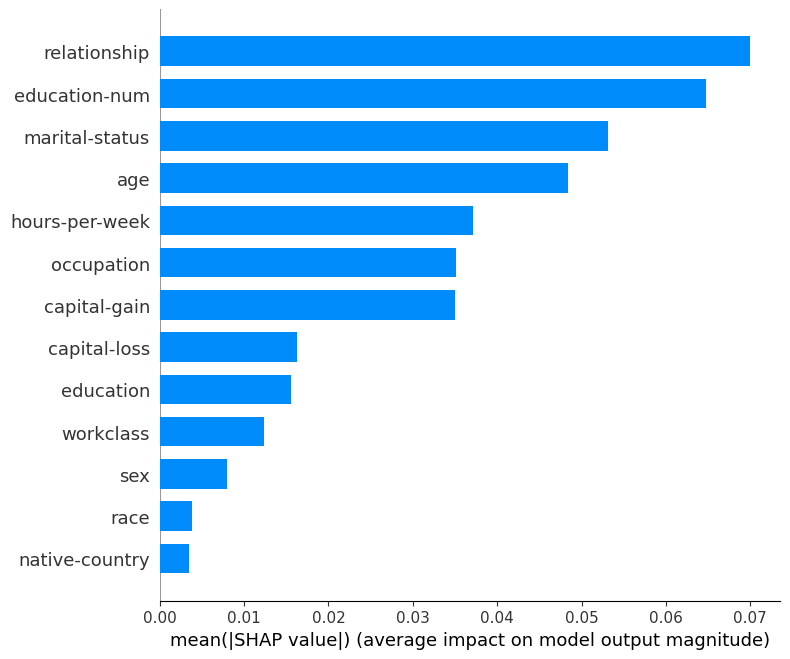

In [20]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")

In [27]:
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['<=50K','>50K'], discretize_continuous=True)
exp = lime_explainer.explain_instance(jane_df.values[0], lambda x: model_adult.predict_proba(x))
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [34]:
# Define kernel_width
kernel_width = 3

feature_names = ["Age", "Workclass",
                 "Education-Num", "Marital Status", "Occupation",
                 "Relationship", "Race", "Sex", "Capital Gain",
                 "Capital Loss", "Hours per week", "Country", "Education"]

categorical_features = ["Workclass", "Marital Status", "Occupation", "Relationship", "Race", "Sex", "Country"]

class_names = ['<=50K', '>50K']

categorical_names = {
    1: ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],  # Workclass
    3: ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],  # Marital Status
    4: ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],  # Occupation
    5: ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],  # Relationship
    6: ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],  # Race
    7: ['Female', 'Male'],  # Sex
    11: ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']  # Country
}

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,class_names=class_names, feature_names=X_train.columns,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=kernel_width)
# Choose a sample for explanation
idx = 0

# Explain the prediction using LIME
exp = lime_explainer.explain_instance(X_test.values[idx], model_adult.predict_proba, num_features=13)

# Show the explanation
exp.show_in_notebook()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
